## Aggregate traffic data to grid and compare gridded traffic with gridded NOx data

In [1]:
!pip install geopandas==0.9.0 -q

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely as shp
import matplotlib.pyplot as plt
import xarray as xr
import shutil

In [3]:
da = xr.DataArray(coords=[np.arange(4,10,0.25), np.arange(43,49,0.25)], dims=['lon', 'lat'])

#### Load NOx data

In [4]:
nox = xr.open_dataset('./data/nox/coco_hourly_study_region.nc')['EMISSIONS_2019']
nox

<xarray.DataArray 'EMISSIONS_2019' (time: 720, latitude: 60, longitude: 61)>
[2635200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 4.0 4.1 4.2 4.3 4.4 ... 9.6 9.7 9.8 9.9 10.0
  * latitude   (latitude) float32 43.05 43.15 43.25 43.35 ... 48.75 48.85 48.95
  * time       (time) datetime64[ns] 2019-05-01 ... 2019-05-30T23:00:00
Attributes:
    standard_name:  NOx_EMISSIONS_2019
    long_name:      NOX_EMISSIONS_2019
    units:          kg m-2 s-1

#### Create grid based on NOx data coordinates

In [5]:
grid = nox.mean('time').to_dataframe().reset_index()
grid['latitude'] = np.round(grid.latitude, decimals=2)
grid = gpd.GeoDataFrame(grid, geometry=gpd.points_from_xy(grid.longitude, grid.latitude))
grid.geometry = grid.buffer(0.05).envelope
grid.crs = 'epsg:4326'
grid.head()

,latitude,longitude,EMISSIONS_2019,geometry
0,43.05,4.0,3.410211e-12,"POLYGON ((3.95000 43.00000, 4.05000 43.00000, ..."
1,43.05,4.1,6.091832e-12,"POLYGON ((4.05000 43.00000, 4.15000 43.00000, ..."
2,43.05,4.2,2.365509e-12,"POLYGON ((4.15000 43.00000, 4.25000 43.00000, ..."
3,43.05,4.3,3.209276e-12,"POLYGON ((4.25000 43.00000, 4.35000 43.00000, ..."
4,43.05,4.4,4.465190e-12,"POLYGON ((4.35000 43.00000, 4.45000 43.00000, ..."


#### Load traffic data

In [6]:
traffic = gpd.read_file('data/traffic/4_43_10_49/20210718_0915.zip')
traffic

,DE,PC,QD,LE,SU,SP,JF,FF,CN,geometry
0,Dietfurt,10194,+,0.23058,50.69,50.69,0.38679,53.0,0.74,"MULTILINESTRING ((9.08232 47.34337, 9.08233 47..."
1,Aeuli-Tunnel,27519,+,1.14372,74.15,74.15,0.56666,79.2,0.79,"MULTILINESTRING ((9.08185 47.34134, 9.08176 47..."
2,Flooz-Tunnel,27518,+,0.52236,75.80,75.80,0.46614,80.0,0.77,"MULTILINESTRING ((9.08018 47.33156, 9.08024 47..."
3,Flooz,10192,+,1.59761,79.64,79.64,0.02855,79.9,0.77,"MULTILINESTRING ((9.08048 47.32687, 9.08050 47..."
4,Wattwil-Tunnel,27517,+,2.14947,79.31,79.31,0.07615,80.0,0.79,"MULTILINESTRING ((9.07965 47.31284, 9.07954 47..."
...,...,...,...,...,...,...,...,...,...,...
75667,Ventabren,4628,-,3.00811,54.82,54.82,0.11965,55.4,0.90,"MULTILINESTRING ((5.25970 43.54231, 5.25982 43..."
75668,D543,4629,-,4.75630,71.49,71.49,0.00000,63.6,0.88,"MULTILINESTRING ((5.29358 43.54721, 5.29460 43..."
75669,Éguilles est,4630,-,1.54228,61.90,61.90,0.00000,55.3,0.86,"MULTILINESTRING ((5.35078 43.54407, 5.35104 43..."
75670,Célony ouest,4631,-,4.14452,51.74,51.74,0.00000,51.3,0.85,"MULTILINESTRING ((5.36887 43.54193, 5.36905 43..."


#### Aggregate traffic data to this grid

In [ ]:
%%time 

sindex = traffic.sindex
# traffic = traffic.set_crs('epsg:4326')

In [ ]:
%%time 

for index, row in grid.iterrows():
    if index%40==0:
        print(index)
    geom = grid.iloc[index:index+1]
    possible = list(sindex.intersection(geom.total_bounds))
    pdf = traffic.iloc[possible]
    clipped = gpd.clip(pdf, geom)
    grid.loc[index, 'traffic'] = (clipped.length).sum()

#### Correlation between traffic and emissions

In [ ]:
plt.scatter(grid.EMISSIONS_2019, grid.traffic)
plt.xlabel('COCO Emissions (May 2019 mean)')
plt.ylabel('Real-time traffic density (4th July, 2021, 7 PM)')
# plt.savefig('Traffic_emissions_correlation.png', dpi=240)

In [191]:
import scipy.stats as ss

In [192]:
r = ss.pearsonr(grid.EMISSIONS_2019, grid.traffic)[0]
print("Correlation coefficient R = %.3f"%(r))

Correlation coefficient R = 0.455


#### Temporal variation

In [5]:
import os
from datetime import datetime as dt

In [6]:
nox_hourly = nox.groupby(nox.time.dt.hour).mean()

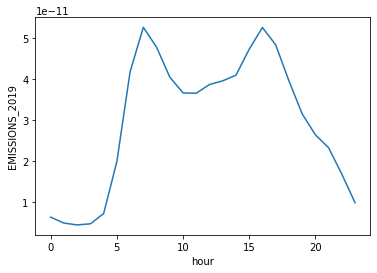

In [7]:
nox_hourly.mean(['latitude', 'longitude']).plot()

In [8]:
files = [x for x in os.listdir('./data/traffic/4_43_10_49/') if (x[-4:] == '.zip')]
files = [x for x in files if int(x[-11:-9])>=18]

In [9]:
files_ = []
for i in range(24):
    for file in files:
        if int(file[-8:-6]) == i:
            files_.append(file)
            break

In [14]:
%%time

for index, file in enumerate(files_):
    
    print('%s\tof %s.'%(index+1, len(files_)))
    
    if index==0:
        gdf = gpd.read_file('./data/traffic/4_43_10_49/%s'%file)
        gdf = gdf[['DE', 'PC', 'QD', 'LE', 'geometry', 'JF']]
        gdf = gdf.rename(columns={'JF':pd.to_datetime(dt.strptime('%s'%file.split('.')[0], '%Y%m%d_%H%M'))})
    
    else:
        gdf_ = gpd.read_file('./data/traffic/4_43_10_49/%s'%file)
        gdf_ = gdf_[['DE', 'PC', 'QD', 'LE', 'geometry', 'JF']]
        gdf_ = gdf_.rename(columns={'JF':pd.to_datetime(dt.strptime('%s'%file.split('.')[0], '%Y%m%d_%H%M'))})
        
        # merge with first gdf
        gdf = pd.merge(gdf, gdf_, on=['DE', 'PC', 'QD', 'LE', 'geometry'])
        del gdf_

1	of 15.
2	of 15.
3	of 15.
4	of 15.
5	of 15.
6	of 15.
7	of 15.
8	of 15.
9	of 15.
10	of 15.
11	of 15.
12	of 15.
13	of 15.
14	of 15.
15	of 15.
CPU times: user 6min 43s, sys: 1.22 s, total: 6min 44s
Wall time: 7min 17s


In [15]:
right = gdf.iloc[:,5:]
right.columns = right.columns.astype('datetime64[ns]') + pd.to_timedelta(0, 'm')
left = gdf.iloc[:,:5]

In [16]:
right = right.groupby(right.columns.hour, axis=1).mean()

In [17]:
gdf = left.join(right)

In [18]:
def agg_to_grid(da, gdf, timestep=None, var_name='new_var'):
    'Aggregate geodataframe of points or lines to grid defined by xarray DataArray.'
    
#     if gdf.crs == None:
#         gdf = gdf.set_crs('epsg:4326')
    if type(da) == xr.DataArray:
        print('Converting to Xarray Dataset')
        da = da.to_dataset(name='emissions')
        da[var_name] = xr.zeros_like(da['emissions'])
        
    if 'x' in da.dims:
        coords = ['x','y']
    elif 'lon' in da.dims:
        coords = ['lon', 'lat']
    elif 'longitude' in da.dims:
        coords = ['longitude', 'latitude']

    lons = da[coords[0]].values
    lats = da[coords[1]].values
    
    sindex = gdf.sindex
    
    xstep = da[coords[0]][1].values - da[coords[0]][0].values
    ystep = da[coords[1]][1].values - da[coords[1]][0].values
    
    assert (xstep - ystep)/xstep < 0.001, 'Grid is not square'

    for lon in da[coords[0]].values:
#         print(lon)
        for lat in da[coords[1]].values:
            geom = shp.geometry.Point(lon, lat).buffer(xstep/2.).envelope
            possible = list(sindex.intersection(geom.bounds))
            pdf = gdf.iloc[possible]
            
            clipped = gpd.clip(pdf, geom)
            length = (clipped.LE * clipped.JF).sum()
            if timestep != None:
                da[var_name].loc[timestep, lat, lon] = length
            else:
                da[var_name].loc[lat, lon] = length

    return da

In [19]:
%%time

print('Computing spatial index.')
sindex = gdf.sindex
print('Computed spatial index.')

da = nox_hourly.to_dataset(name='emissions')
da['traffic'] = xr.zeros_like(da['emissions'])

if 'x' in da.dims:
    coords = ['x','y']
elif 'lon' in da.dims:
    coords = ['lon', 'lat']
elif 'longitude' in da.dims:
    coords = ['longitude', 'latitude']
    
xstep = da[coords[0]][1].values - da[coords[0]][0].values
ystep = da[coords[1]][1].values - da[coords[1]][0].values

assert (xstep - ystep)/xstep < 0.001, 'Grid is not square.'

for lon in da[coords[0]].values:
#     print(lon)
    for lat in da[coords[1]].values:
        geom = shp.geometry.Point(lon, lat).buffer(xstep/2.).envelope
        possible = list(sindex.intersection(geom.bounds))
        pdf = gdf.iloc[possible]

        clipped = gpd.clip(pdf, geom)
        for hour in range(24):
            if hour in gdf.columns:
                length = (clipped['LE'] * clipped.loc[:,hour]).sum()
                da['traffic'].loc[hour, lat, lon] = length

#     nox_hourly = agg_to_grid(nox_hourly, gdf, timestep=hour, var_name='traffic')
#         tests.append(agg_to_grid(nox_hourly, gdf, timestep=hour, var_name='traffic'))

Computing spatial index.
Computed spatial index.
CPU times: user 2min 26s, sys: 48.3 ms, total: 2min 26s
Wall time: 2min 26s


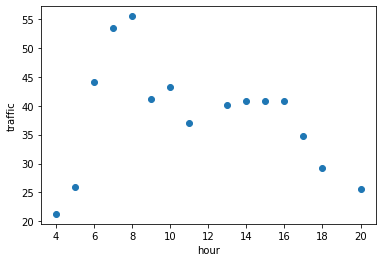

In [20]:
hourly = da['traffic'].mean(['latitude', 'longitude'])
xr.where(hourly==0, np.nan, hourly).plot(marker='o', linestyle='None')

In [24]:
(da['traffic'].isel(hour=10) - da['traffic'].isel(hour=11)).mean()

<xarray.DataArray 'traffic' ()>
array(6.277618, dtype=float32)

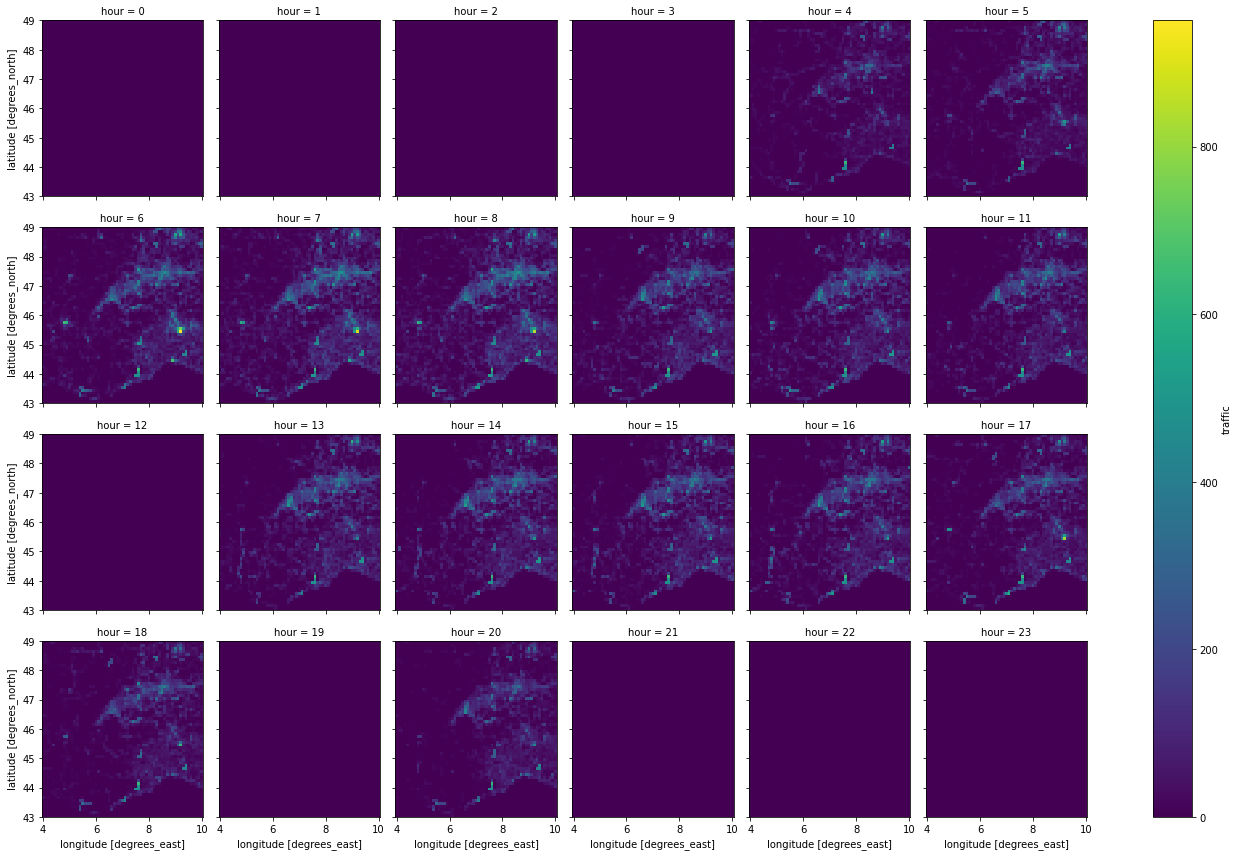

In [23]:
da['traffic'].plot(col='hour', col_wrap=6)

In [29]:
# nox_hourly.to_netcdf('./data/emissions_traffic_hourly_merged.nc')

In [30]:
hourwise = nox_hourly.mean(['latitude', 'longitude'])

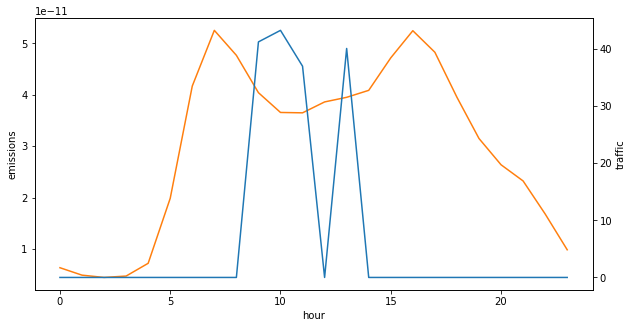

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
hourwise.emissions.plot(ax=ax, c='C1')
ax2 = ax.twinx()
hourwise.traffic.plot(ax=ax2, c='C0')

In [31]:
df = nox_hourly.to_dataframe()

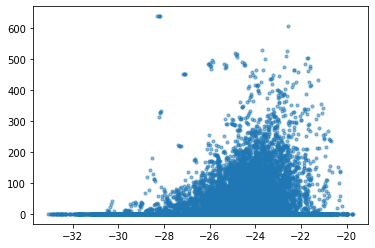

In [38]:
plt.scatter(np.log(df.emissions), df.traffic, s=10, alpha=0.5)

In [39]:
import scipy.stats as ss

In [40]:
r = ss.pearsonr(np.log(df.emissions), df.traffic)[0]
print("Correlation coefficient R = %.3f"%(r))

Correlation coefficient R = 0.162


In [41]:
for hour in range(24):
    df_ = df.loc[hour]
    r = ss.pearsonr(np.log(df_.emissions), df_.traffic)[0]
    print('%s \t %.3f'%(hour, r))

0 	 nan
1 	 nan
2 	 nan
3 	 nan
4 	 nan
5 	 nan
6 	 nan
7 	 nan
8 	 nan
9 	 0.295
10 	 0.318
11 	 0.289
12 	 nan
13 	 0.287
14 	 nan
15 	 nan
16 	 nan
17 	 nan
18 	 nan
19 	 nan
20 	 nan
21 	 nan
22 	 nan
23 	 nan


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
